In [1]:
import sys, os, warnings
from argparse import Namespace
warnings.filterwarnings("ignore")

import torch as ch
from torchvision import transforms
import numpy as np
from PIL import Image
from tqdm import tqdm
from robustness import datasets

sys.path.append('..')
#from utils.custom_vgg import vgg16_bn, vgg16
#from utils.classifier import load_classifier
import helpers.context_helpers as coh
import helpers.load_helpers as lh
import helpers.gen_helpers as gh
import helpers.vis_helpers as vh
from helpers.grid_helpers import edit_model

%matplotlib inline

In [2]:
DATASET_NAME = 'ImageNet'
EPS = 0
LAYERNUM = 12
REWRITE_MODE = 'editing'

ret = lh.get_default_paths(DATASET_NAME, EPS)
DATASET_PATH, MODEL_PATH, MODEL_CLASS, ARCH, CD = ret

In [3]:
ret = coh.reload_classifier(MODEL_PATH, MODEL_CLASS, ARCH,
                            DATASET_NAME, LAYERNUM) 

model, context_model, target_model = ret[:3]

In [4]:
if DATASET_NAME == 'ImageNet':
    dataset = datasets.ImageNet(DATASET_PATH)
else:
    dataset = datasets.Places365(DATASET_PATH)

train_loader, val_loader = dataset.make_loaders(batch_size=32, workers=8)

==> Preparing dataset imagenet..


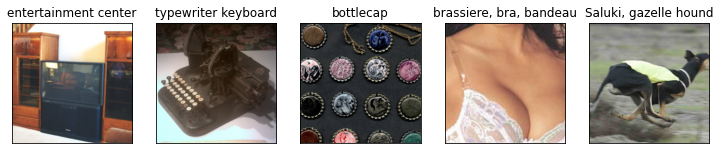

In [5]:
x, y = next(iter(val_loader))
vh.show_image_row([x[:5]], tlist=[[CD[c.item()] for c in y[:5]]])

In [6]:
#targets, preds, acc = gh.eval_accuracy(model, val_loader, workers=10,
#                                       batch_size=128, cache_file=None)

In [7]:
img_dir = '/mnt/nfs/projects/editing/datasets/scraped/snow'
scraped = {}
valid = {}
IMG_SIZE = 256 if DATASET_NAME == 'Places' else 224
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
    ])

for c in os.listdir(img_dir):
    l = []
    for f in os.listdir(os.path.join(img_dir, c)):
        if 'htm' in f: continue
        img_path = os.path.join(img_dir, c, f)
        img = Image.open(img_path)
        l.append(transform(img)[:3, :, :])
    scraped[c] = ch.stack(l)
    
    # valid[c] = [k for k, v in CD.items() if c in v]
    #valid[c] = [k for k, v in CD.items() if c.replace('-', '/') == v[3:]
     #                                       or ((c == 'general_store-outdoor')
      #                                          and (v == '/s/shopfront'))]
    valid[c] = [k for k, v in CD.items() if c.split('_')[0] in v.replace(' ', '')]
    if c == 'cow':
        valid[c] = [k for k, v in CD.items() if v == 'ox' or 'bison' in v]
    
    print(f'{c}\n'
          f'- valid labels: {[CD[cc] for cc in valid[c]]}\n'
          f'- examples: {len(scraped[c])}')

racingcar
- valid labels: ['racer, race car, racing car']
- examples: 20
armytank
- valid labels: ['tank, army tank, armored combat vehicle, armoured combat vehicle']
- examples: 17
firetruck
- valid labels: ['fire engine, fire truck']
- examples: 20
carwheel
- valid labels: ['car wheel']
- examples: 20
trafficlight
- valid labels: ['traffic light, traffic signal, stoplight']
- examples: 9
schoolbus
- valid labels: ['school bus']
- examples: 22
motorscooter
- valid labels: ['motor scooter, scooter']
- examples: 21


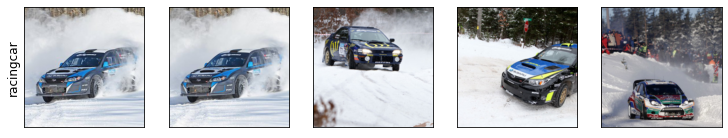

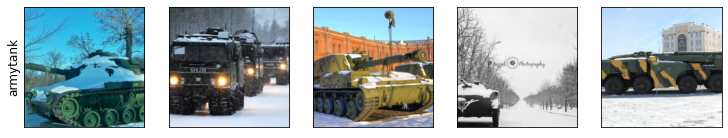

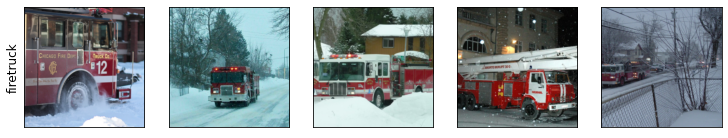

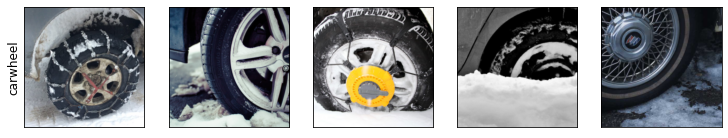

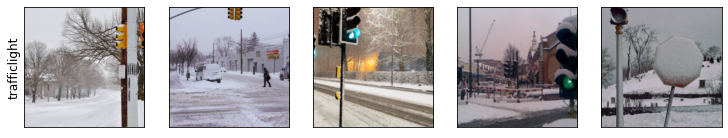

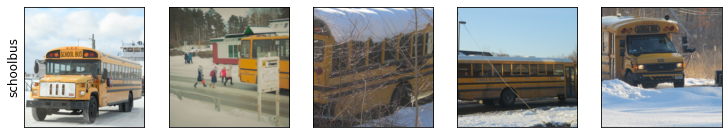

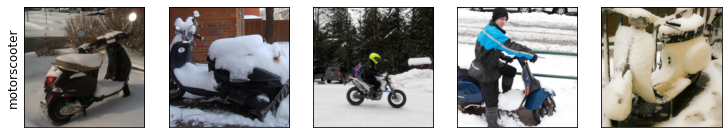

In [8]:
for c, x in scraped.items():
    vh.show_image_row([x[:5]],[c])

In [17]:
results = {'pre': {}, 'post': {}}
preds = {'pre': {}, 'post': {}}
for c, x in scraped.items():
    with ch.no_grad():
        pred = model(x.cuda()).argmax(axis=1)
    correct = [p for p in pred if p in valid[c]]
    acc = len(correct) / len(x)
    results['pre'][c] = acc
    preds['pre'][c] = pred
    print(f'{c}. new: {acc:.2f}',) 
          #old:*[f'{acc_per_class[v]:.2f}' for v in valid[c]])

racingcar. new: 0.40
armytank. new: 0.47
firetruck. new: 0.90
carwheel. new: 0.40
trafficlight. new: 0.67
schoolbus. new: 0.64
motorscooter. new: 0.24


In [10]:
ANNO_DIR = '/mnt/nfs/projects/editing/datasets/scraped_annotated'
CLASS = 'road:15:05:2021_17:39:17.pt'
anno = ch.load(os.path.join(ANNO_DIR, CLASS))

imgs, masks = anno['imgs'], anno['masks']
#vh.show_image_row([imgs,
 #                  masks,
  #                 imgs * masks + (imgs / 3 + 2/3) * (1-masks)])

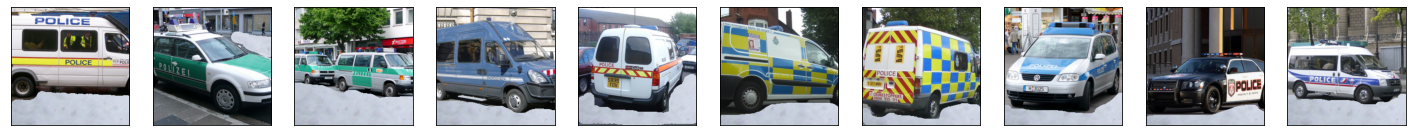

In [11]:
def tile_image(img):
    tiled = Image.new('RGB', (800,800), "black")
    pixels = img.load()
    pixels_tiled = tiled.load()
    for i in range(800):
        for j in range(800):
            pixels_tiled[i,j] = pixels[i % 256,j % 256]
    return tiled

img_path = '/mnt/nfs/home/tsipras/5223282673_bf1772c6fe_o.jpg'
img = Image.open(img_path)
#img = tile_image(img)
    
pattern = transform(img)[:3, :, :]
#show_image_row([pattern.unsqueeze(0)])

mixed = imgs * (1-masks) + pattern.unsqueeze(0) * masks
vh.show_image_row([mixed])

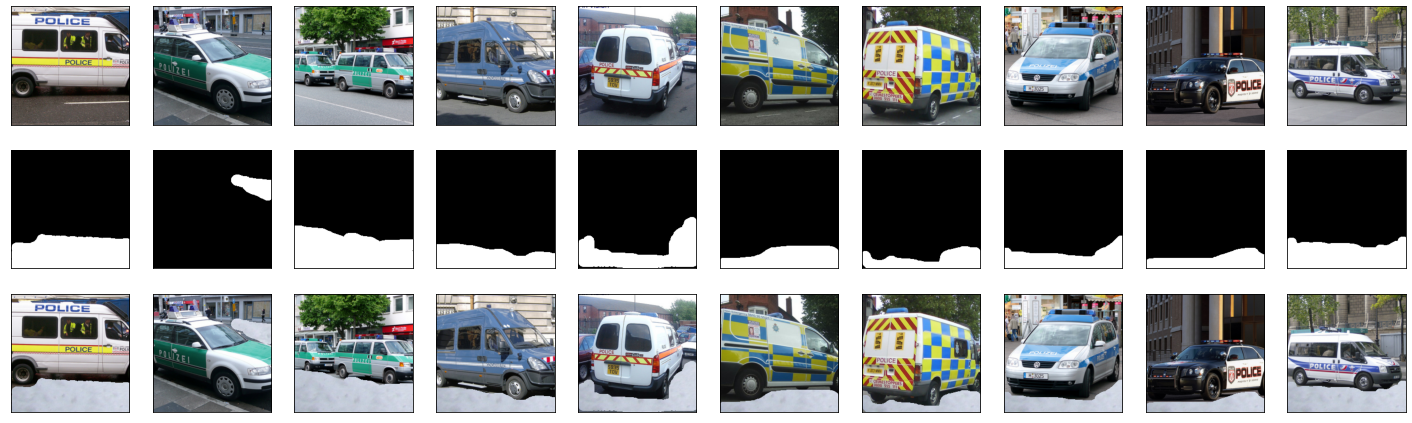

In [14]:
vh.show_image_row([imgs, masks, mixed], filename='../grid/paper_figures/Figures/real/snow_train.pdf')

In [18]:
ZM_k = None
COV_DIR = '/mnt/nfs/home/tsipras/covariances'
if REWRITE_MODE == 'editing':
    cov_name = f"{DATASET_NAME}_{ARCH}_{0}_layer{LAYERNUM}_imgs{len(val_loader.dataset.targets)}"
    _, ZM_k = coh.get_cov_matrix(val_loader, context_model, 
                            batch_size=2000, 
                            key_method='zca',
                            caching_dir=os.path.join(COV_DIR, cov_name))

Found precomputed cov matrices, returning...


In [19]:
args = {'ntrain': 10,
        'rank': 1,
        'arch': ARCH,
        'nsteps': 20000 if REWRITE_MODE == 'editing' else 400,     
        'nsteps_proj': 10,
        'lr': 1e-4,
        'restrict_rank': True,
        'use_mask': True,
        'layernum': LAYERNUM,
        'mode_rewrite': REWRITE_MODE}
args = Namespace(**args)

data_dict = {'train_data': 
                {'imgs': imgs,
                 'manip_imgs': mixed,
                 'masks': masks,
                 'labels': anno['labels']}}

context_model = edit_model(args, data_dict, context_model, target_model=target_model, ZM_k=ZM_k)

torch.Size([196, 512])


tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>):   0%|          | 0/20000 [00:00<?, ?it/s]

--In here torch.Size([10, 1, 224, 224])


tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 20000/20000 [00:50<00:00, 394.65it/s]

Loss (orig, final): 0.0019218219676986337 0.0006972321425564587
L2 norm of weight change: 16.36850929260254


In [20]:
for c, x in scraped.items():
    with ch.no_grad():
        pred = model(x.cuda()).argmax(axis=1)
    correct = [p for p in pred if p in valid[c]]
    acc = len(correct) / len(x)
    results['post'][c] = acc
    preds['post'][c] = pred
    print(f'{c}. new: {acc:.2f}, old:',
         )#*[f'{acc_per_class[v]:.2f}' for v in valid[c]])

racingcar. new: 1.00, old:
armytank. new: 0.65, old:
firetruck. new: 0.90, old:
carwheel. new: 0.45, old:
trafficlight. new: 0.89, old:
schoolbus. new: 0.77, old:
motorscooter. new: 0.48, old:


In [21]:
for c in scraped.keys():
    print(f'{c}: {results["pre"][c]:.2f} -> {results["post"][c]:.2f}')

racingcar: 0.40 -> 1.00
armytank: 0.47 -> 0.65
firetruck: 0.90 -> 0.90
carwheel: 0.40 -> 0.45
trafficlight: 0.67 -> 0.89
schoolbus: 0.64 -> 0.77
motorscooter: 0.24 -> 0.48


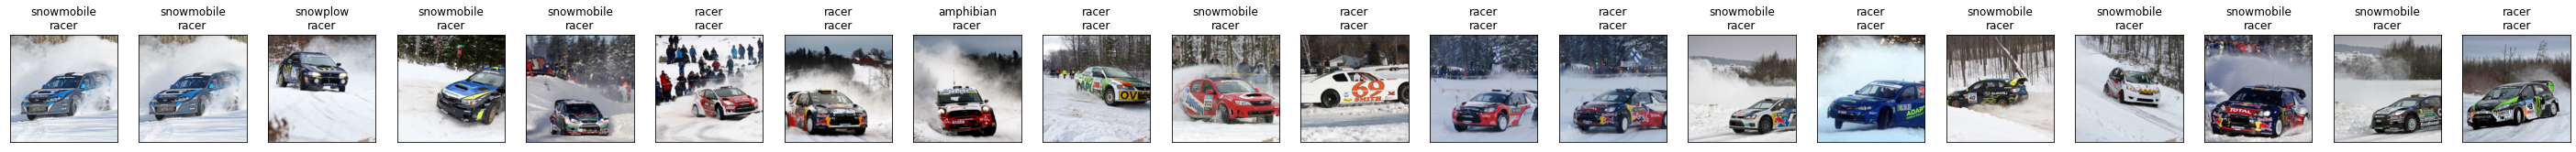

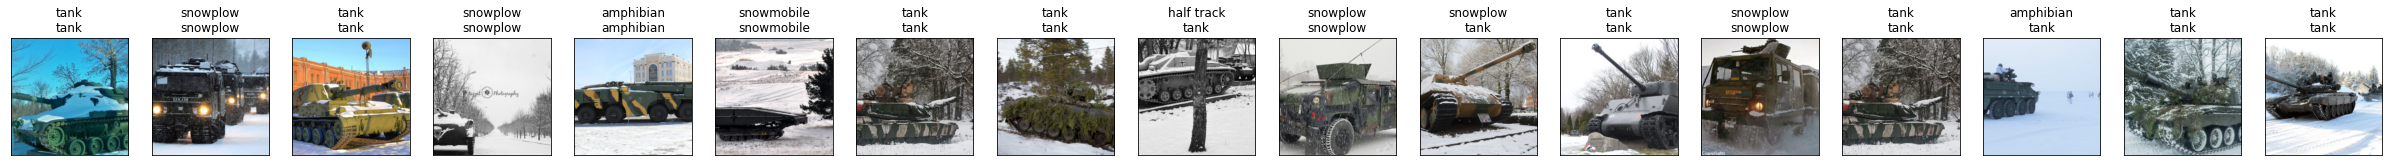

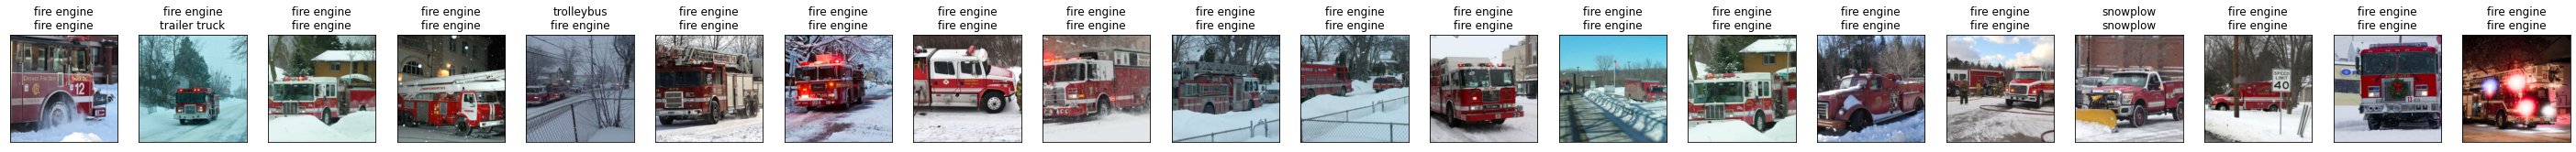

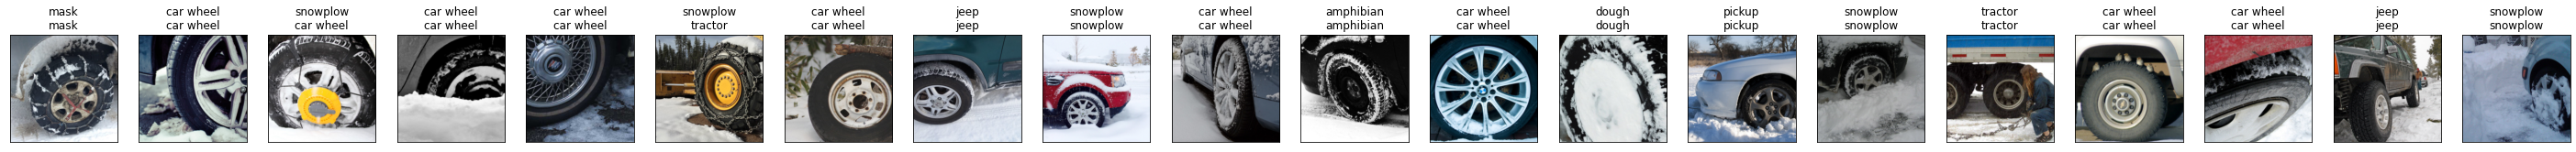

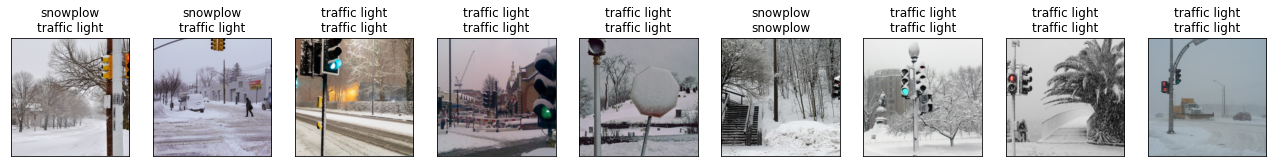

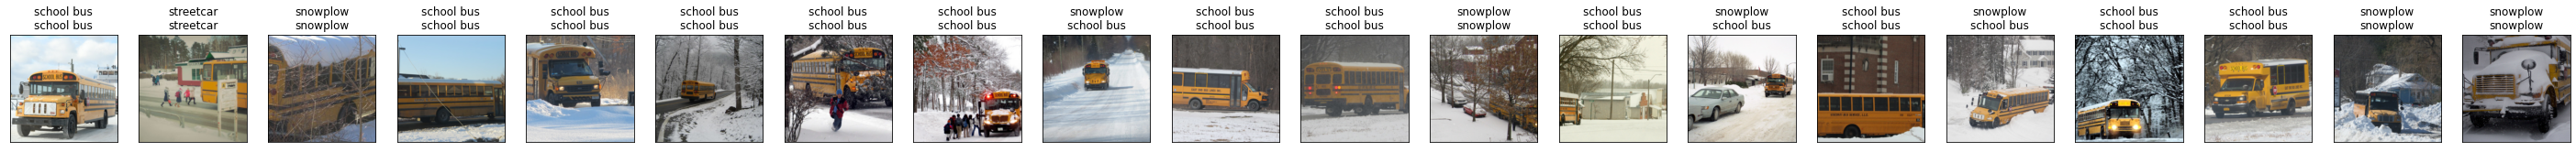

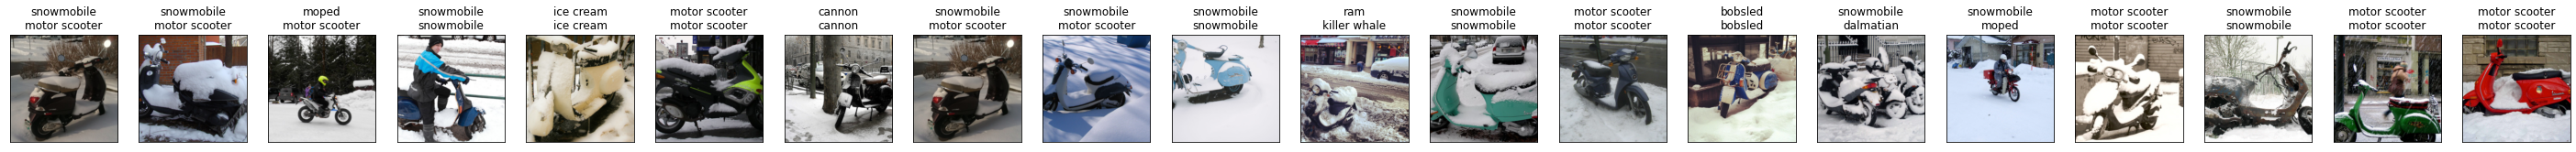

In [49]:
N = 20
for c, x in scraped.items():
    vh.show_image_row([x[:N]],
                      tlist=[["\n".join([CD[int(ll)].split(',')[0] for ll in [pre, post]])
                              for pre, post in zip(preds['pre'][c][:N], 
                                                      preds['post'][c][:N])]])

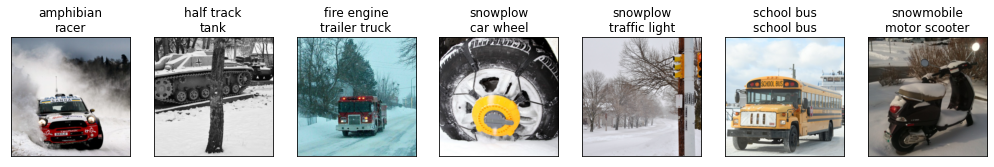

In [50]:
indices = [7, 8, 1, 2, 0, 0, 0]

xs = []
tlist = []

for ii, (c, x) in enumerate(scraped.items()):
    idx = indices[ii]
    xs.append(x[idx:idx+1])
    tlist.extend(["\n".join([CD[int(ll)].split(',')[0] for ll in [pre, post]])
                          for pre, post in zip(preds['pre'][c][idx:idx+1], 
                                                  preds['post'][c][idx:idx+1])])
vh.show_image_row([ch.cat(xs)],
                  tlist=[tlist],
                  filename='../grid/paper_figures/Figures/real/snow_test.pdf')